In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from __future__ import unicode_literals, print_function, division

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

from nltk.tokenize import word_tokenize

from io import open
import unicodedata
import string
import re
import random

from sklearn.model_selection import train_test_split 

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

##import os
##for dirname, _, filenames in os.walk('/kaggle/input'):
##    for filename in filenames:
##        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
!pip install rouge
#Import library to calculate the evaluation metric
from rouge import FilesRouge, Rouge


In [3]:
data_path = '/kaggle/input/news-summary/news_summary_more.csv'
###glove_path = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'

In [4]:
dataset = pd.read_csv(data_path,encoding='utf-8')
print('total rows:', len(dataset))
dataset.head()


total rows: 98401


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [5]:
dataset.drop_duplicates(subset=["text"],inplace=True)
#Drop rows with null values in the text variable
dataset.dropna(inplace=True)
dataset.reset_index(drop=True,inplace=True)
# we are using the text variable as the summary and the ctext as the source text
print('Drop null and duplicates, Total rows:', len(dataset))

Drop null and duplicates, Total rows: 98360


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", 
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                       "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                       "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", 
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

punct = "/-'.,?!#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

def expand_contractions(text):
    ''' Expand the contractions (some well-known of them) in a text'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

def remove_mult_spaces(text):
    re_mult_space = re.compile(r"  *") # replace multiple spaces with just one
    return re_mult_space.sub(r' ', text)

def sep_punctuation(text, punct):
# Separate punctuation with whitespaces
    for p in punct:
        text = text.replace(p, f'{p} ')

    return text

def remove_CTL(text):
    url = re.compile(r'\n')
    return url.sub(r' ',text)

def clean_text(text):
    new_text=text
    new_text=new_text.apply(lambda x : x.lower())
    new_text=new_text.apply(lambda x : expand_contractions(x))
    new_text=new_text.apply(lambda x : sep_punctuation(x,punct))
    new_text=new_text.apply(lambda x : remove_mult_spaces(x))
    new_text=new_text.apply(lambda x : remove_CTL(x))
    return new_text

In [7]:
dataset['text']=clean_text(dataset['text'])
dataset['headlines']=clean_text(dataset['headlines'])

Lets create a train and test dataset

In [8]:
x, x_test, y, y_test = train_test_split(dataset['text'].values, dataset['headlines'].values, test_size=0.15, random_state=42)
print('X Length: ',len(x), 'Y Length: ',len(y))
print('X test Length: ',len(x_test), 'Y test Length: ',len(y_test))

X Length:  83606 Y Length:  83606
X test Length:  14754 Y test Length:  14754


In [9]:
#Calculate max_length
len_x=[len(word_tokenize(xi)) for xi in x]
len_y=[len(word_tokenize(yi)) for yi in y]
print(max(len_x), max(len_y))

110 22


**Torch Req**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        words = word_tokenize(sentence)
        for word in words:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def fit(self, data):
        ''' data: list of documents
        '''
        for text in data:
            self.addSentence(text)
        
        self.addWord('<UNK>')

    def transform2indexes(self, sentence):
        return [self.word2index[word] if word in self.word2index else self.word2index['<UNK>'] 
                for word in word_tokenize(sentence)]
        #return [self.word2index[word] for word in word_tokenize(sentence)] #.split(' ')]

    def transform2tensor(self, sentence):
        indexes = self.transform2indexes(sentence)
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


In [12]:
input_lang = Lang(x)
output_lang = Lang(y)

In [13]:
input_lang.fit(x)

In [14]:
output_lang.fit(y)

In [15]:
print(input_lang.n_words,output_lang.n_words)
print(len(input_lang.word2index), len(output_lang.word2index))

89804 35781
89802 35779


In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
MAX_LENGTH = 115

In [19]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [21]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [22]:

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [23]:
def trainIters(encoder, decoder, x, y, vocab_input, vocab_output, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    print("Training....")
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    #training_pairs = [tensorsFromPair(random.choice(pairs))
    #                  for i in range(n_iters)]
    training_x = [vocab_input.transform2tensor(random.choice(x)) for i in range(n_iters)]
    training_y = [vocab_output.transform2tensor(random.choice(y)) for i in range(n_iters)]

    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        if iter% 1000 == 0:
            print(iter,"/",n_iters + 1)
        #training_pair = training_pairs[iter - 1]
        #input_tensor = training_pair[0]
        #target_tensor = training_pair[1]
        input_tensor = training_x[iter - 1]
        target_tensor = training_y[iter - 1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = input_lang.transform2tensor(sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Training....
1m 39s (- 48m 19s) (500 3%) 7.0143
1000 / 15001
3m 0s (- 42m 8s) (1000 6%) 7.2438
4m 21s (- 39m 16s) (1500 10%) 6.9083
2000 / 15001
5m 43s (- 37m 11s) (2000 13%) 6.9881
7m 4s (- 35m 22s) (2500 16%) 6.9644
3000 / 15001
8m 26s (- 33m 45s) (3000 20%) 6.9088
9m 47s (- 32m 10s) (3500 23%) 6.8170
4000 / 15001
11m 8s (- 30m 38s) (4000 26%) 6.8220
12m 29s (- 29m 8s) (4500 30%) 6.8086
5000 / 15001
13m 50s (- 27m 40s) (5000 33%) 6.7220
15m 10s (- 26m 13s) (5500 36%) 6.6364
6000 / 15001
16m 32s (- 24m 48s) (6000 40%) 6.7508
17m 53s (- 23m 23s) (6500 43%) 6.5678
7000 / 15001
19m 13s (- 21m 58s) (7000 46%) 6.6755
20m 34s (- 20m 34s) (7500 50%) 6.6082
8000 / 15001
21m 56s (- 19m 11s) (8000 53%) 6.5778
23m 17s (- 17m 48s) (8500 56%) 6.5268
9000 / 15001
24m 38s (- 16m 25s) (9000 60%) 6.5211
25m 58s (- 15m 2s) (9500 63%) 6.6262
10000 / 15001
27m 20s (- 13m 40s) (10000 66%) 6.5272
28m 41s (- 12m 17s) (10500 70%) 6.6085
11000 / 15001
30m 2s (- 10m 55s) (11000 73%) 6.4503
31m 22s (- 9m 33s) (

<Figure size 432x288 with 0 Axes>

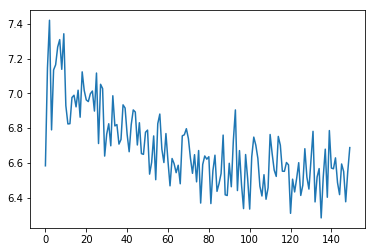

In [25]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, x, y, input_lang, output_lang, 15000, print_every=500)

In [26]:
torch.save(encoder1.state_dict(), './enc.w')
torch.save(attn_decoder1.state_dict(), './att.w')

In [27]:
text=x[400]
print(text)
dec_sent,dec_tensor = evaluate(encoder1, attn_decoder1, text)
#dec_sent = predict_summary(encoder1, attn_decoder1, input_lang.transform2tensor(x[0]), output_lang)
print(dec_sent)
#print(dec_tensor)

finance minister arun jaitley has said that former pm jawaharlal nehru had written to rbi stating that economic policy is determined by government, while rbi has autonomy over monetary policy. " we are the sovereign government. . . the most important stakeholder [ in managing] economy, " he added. he also questioned how a discussion on rbi' s functioning could be deemed the institution' s " destruction" . 
['us', 'of', "'", "'", ',', "'", 'in', ':', '<EOS>']


In [28]:
predicted_summaries = []
for doc in x_test:
    pred_summ,_ = evaluate(encoder1, attn_decoder1, doc, max_length=MAX_LENGTH)
    predicted_summaries.append(' '.join(pred_summ[:-1]))

labeled_summaries = y_test
print(len(x_test), len(labeled_summaries), len(predicted_summaries))

14754 14754 14754


In [29]:
print(predicted_summaries[300],labeled_summaries[300])
print(predicted_summaries[500],labeled_summaries[500])
print(predicted_summaries[1000],labeled_summaries[1000])
print(predicted_summaries[1500],labeled_summaries[1500])
print(predicted_summaries[1800],labeled_summaries[1800])

us of ' ' , ' : i take tremendous pride in being a woman of colour: priyanka
us of ' ' , ' : ' rafale aircraft very capable, waiting for it: iaf vice chief
us of ' ' , ' : ' astronomers find sun- like star that devoured its own planets
' ' , to ' in : ' fb scandal firm to operate under new decoy name: report
govt of s ' , ' in : ' ram rahim was issued 2 passports with different names


Lets evaluate with the ROUGE metric

In [30]:
def save_textfile(filename, strings):
    ''' Save the contect of a list of strings to a file called filename
    
        Input:
           - filename: name of the file to save the strings
           - strings: a list of string to save to disk
    '''
    
    with open(filename, 'w') as f:
        for item in strings:
            #Remove any \n in the string
            item = remove_CTL(item)
            f.write("%s\n" % item)

def eval_metrics(preds, targets, avg=True):
    ''' Evaluate the ROUGE metrics ROUGE-2 and ROUGE-L for every pair predicted summary - target summary
    
        Input:
           - preds: list of strings, predicted summaries
           - targets: list of string, target summaries
        Output:
            - rouge2_f_metric: list of float, the Rouge-2 fscore for every predicted summary
            - rougel_f_metric: list of float, the Rouge-L fscore for every predicted summary
    '''
    #Lets calculate the rouge metrics for every document
    rouge = Rouge()
    scores = rouge.get_scores(preds, targets, avg)
    # Create the output variables
    if avg:
        rouge2_f_metric = scores['rouge-2']['f']
        rougel_f_metric = scores['rouge-l']['f']
    else:
        rouge2_f_metric = [score['rouge-2']['f'] for score in scores]
        rougel_f_metric = [score['rouge-l']['f'] for score in scores]
       
    
    return rouge2_f_metric, rougel_f_metric

In [31]:
#evaluateRandomly(encoder1, attn_decoder1)
r2_f, rl_f = eval_metrics(predicted_summaries, list(labeled_summaries), False)
print('Mean Rouge-2 FScore: ',np.mean(r2_f), 'Mean Rouge-L FScore: ',np.mean(rl_f))
#print(r2_f,rl_f)
#dataset['rouge2-f'] = r2_f
#dataset['rougeL-f'] = rl_f

Mean Rouge-2 FScore:  0.0005145305303688093 Mean Rouge-L FScore:  0.05840968928490053
